In [74]:
!pip install -q scikit-learn==1.6.*
!pip install -q dtreeviz==2.2.*
!pip install -q umap-learn==0.5.*
!pip install -q seaborn==0.13.*
!pip install -q hdbscan==0.8.*

In [5]:
import sklearn as skl
import dtreeviz as dtv
import pandas as pd
import numpy as np
from sklearn import set_config
set_config(transform_output = "pandas")

### Load and show data

In [2]:
df = pd.read_csv('data/synthetic_survey_data.csv')
df.head(n=5)

,country,age,sex,ever_used_dss,farm_size,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10
0,Australia,33,Female,False,149.628270,3,4,2,5,1,3,1,2,3,5
1,Canada,30,Female,True,426.810366,4,4,2,4,2,2,3,4,1,1
2,Canada,65,Female,True,508.119193,4,4,2,5,1,3,5,1,1,4
3,UK,62,Male,True,1031.369240,3,4,1,4,2,2,2,3,5,1
4,UK,62,Male,False,161.282096,5,3,3,4,2,2,5,4,3,4


### Transform features

In [4]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Identify features
numerical_features = ['age', 'farm_size'] + [f'Q{i}' for i in range(1, 11)]
categorical_features = ['country']
binary_features = ['sex', 'ever_used_dss']

# Create transformers for all types of features
numerical_transformer = StandardScaler()  # z-score: subtract mean and divide by stdev
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
ordinal_transformer = OrdinalEncoder()  # CAREFEUL: for binary this is ok, for multi-valued categorical you must used OneHotEncoder so no spurious order is introduced

# Create a column transformer to apply different transformations to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features),
        ('bin', ordinal_transformer, binary_features)],
    verbose_feature_names_out=True,  # prefix output features with transformer name
    remainder='drop')                # drop all other columns

tdf = preprocessor.fit_transform(df)
display(tdf.head())

# show how ordinal features were encoded
for col, cats in zip(binary_features, preprocessor.named_transformers_['bin'].categories_):
    print(f"{col}:")
    for i, cat in enumerate(cats):
        print(f"  {cat} → {i}")

,num__age,num__farm_size,num__Q1,num__Q2,num__Q3,num__Q4,num__Q5,num__Q6,num__Q7,num__Q8,num__Q9,num__Q10,cat__country_Australia,cat__country_Canada,cat__country_Mexico,cat__country_UK,cat__country_USA,bin__sex,bin__ever_used_dss
0,-1.189262,-1.187348,-0.613559,0.542326,0.085160,1.499538,-1.370622,-0.104338,-1.525431,-0.765707,-0.021544,1.416939,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.438409,-0.243473,0.444301,0.542326,0.085160,0.454564,0.143877,-0.849611,-0.157331,0.679023,-1.457793,-1.354580,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,1.468307,0.033404,0.444301,0.542326,0.085160,1.499538,-1.370622,-0.104338,1.210768,-1.488073,-1.457793,0.724060,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,1.219160,1.815203,-0.613559,0.542326,-1.334172,0.454564,0.143877,-0.849611,-0.841381,-0.043342,1.414706,-1.354580,0.0,0.0,0.0,1.0,0.0,1.0,1.0
4,1.219160,-1.147664,1.502162,-0.542326,1.504492,0.454564,0.143877,-0.849611,1.210768,0.679023,-0.021544,0.724060,0.0,0.0,0.0,1.0,0.0,1.0,0.0


sex:
  Female → 0
  Male → 1
ever_used_dss:
  False → 0
  True → 1


### Apply UMAP and plot

/home/vid/programiranje/survey_analysis/venv/lib64/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


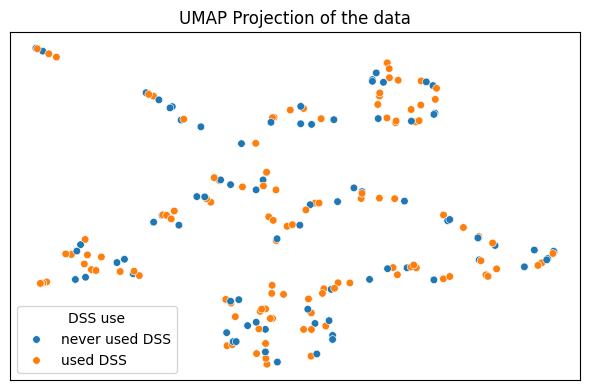

In [ ]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns

# UMAP
color_feature = tdf['bin__ever_used_dss']
data_for_umap = tdf.drop(columns=['bin__ever_used_dss'])
reducer = umap.UMAP(n_neighbors=3, n_components=2, min_dist=0.1, metric='euclidean')
embedding = reducer.fit_transform(data_for_umap)

# plotting: make a DataFrame with data and target
plot_df = tdf[['bin__ever_used_dss']].copy()
plot_df['UMAP1'] = embedding[:, 0]
plot_df['UMAP2'] = embedding[:, 1]
plot_df['DSS Use'] = plot_df['bin__ever_used_dss'].map({0: 'never used DSS', 1: 'used DSS'})

plt.figure(figsize=(6, 4))
ax = sns.scatterplot(
        data=plot_df,
        x='UMAP1', y='UMAP2',
        hue='DSS Use',
        palette='tab10',
        s=30
)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')

plt.title('UMAP Projection of the data')
plt.legend(title='DSS use')
plt.tight_layout()
plt.show()

#### Example: use a numerical feature for coloring

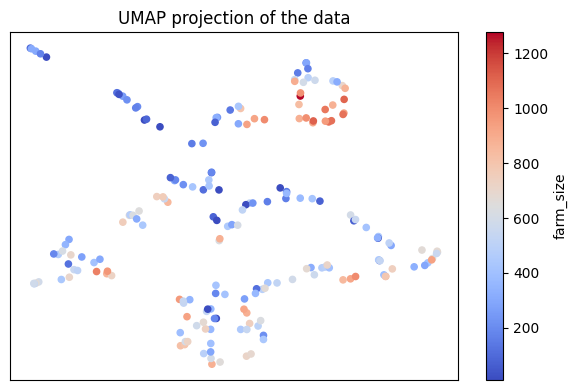

In [24]:
num_feature = 'farm_size'
color_feature = df[num_feature]  # we use non-normalized feature for visualization
fig, ax = plt.subplots(figsize=(6, 4))
scatter = ax.scatter(
    embedding[:, 0], embedding[:, 1],
    c=color_feature,
    cmap='coolwarm',
    s=20
)
plt.colorbar(scatter, label=num_feature)
plt.title('UMAP projection of the data')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()
plt.show()

### Cluster with HDBSCAN and visualize

/home/vid/programiranje/survey_analysis/venv/lib64/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
/home/vid/programiranje/survey_analysis/venv/lib64/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


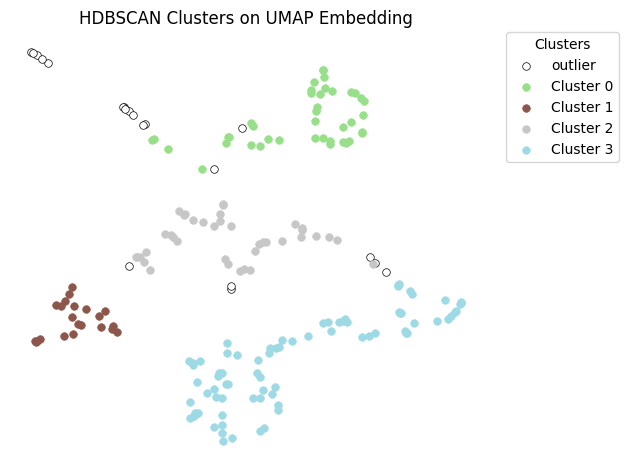

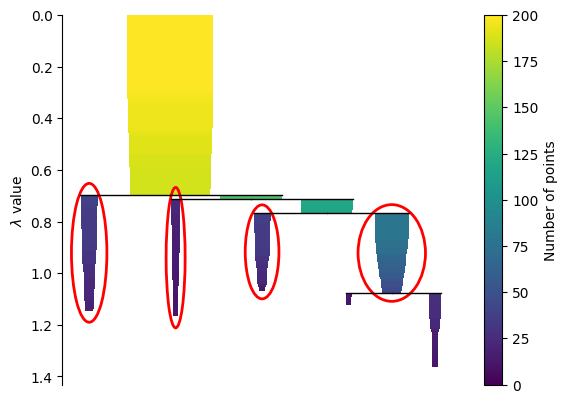

In [68]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=10)
cluster_labels = clusterer.fit_predict(embedding)

unique_labels = np.unique(cluster_labels)
palette = plt.get_cmap('tab20', len(unique_labels))  # Discrete color map

for i, label in enumerate(unique_labels):
    mask = cluster_labels == label
    color = palette(i) if label != -1 else 'white'
    edgecolor = color if label != -1 else 'black'
    label_name = f'Cluster {label}' if label != -1 else 'outlier'
    
    plt.scatter(
        embedding[mask, 0], embedding[mask, 1],
        s=30,
        label=label_name,
        color=color,
        edgecolor=edgecolor,
        linewidth=0.5
    )

plt.legend(
    title='Clusters',
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    borderaxespad=0.
)
plt.title('HDBSCAN Clusters on UMAP Embedding')
plt.axis('off')
plt.tight_layout()
plt.show()

_ = clusterer.condensed_tree_.plot(select_clusters=True)

### Explain clusters with a classification tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

# from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
# import matplotlib.pyplot as plt


# Step 1: prepare data
dftree = df.copy()
dftree['cluster'] = cluster_labels
dftree = dftree[dftree['cluster'] != -1]   # Optional: removing outliers

features = ['country', 'age', 'sex', 'ever_used_dss', 'farm_size'] + [f'Q{i}' for i in range(1, 11)]
target = 'cluster'

X = dftree[features]
y = dftree[target]

# Step 2: encode target - not strictly needed here because target is already ok but needed in general
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)


# Step 3: preprocess features
numerical_features = ['age', 'farm_size'] + [f'Q{i}' for i in range(1, 11)]
categorical_features = ['country']
binary_features = ['sex', 'ever_used_dss']

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(sparse_output=False), categorical_features),
    ('bin', OrdinalEncoder(), binary_features),
], remainder='passthrough', verbose_feature_names_out=False, force_int_remainder_cols=False)  
# numerical features are left intact because classification tree can handle that
# output feature names will not be verbose (prefixed with transformer names)


# Step 4: pipeline
clf = Pipeline([
    ('prep', preprocessor),
    ('tree', DecisionTreeClassifier(min_samples_leaf=10, random_state=42))
])


# Step 5: Train/test split: this is not necessary if we are only looking for explanations
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=dftree[target], random_state=42
)

# Step 6: Fit model
clf.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['country']),
                                                 ('bin', OrdinalEncoder(),
                                                  ['sex', 'ever_used_dss'])],
                                   verbose_feature_names_out=False)),
                ('tree',
                 DecisionTreeClassifier(min_samples_leaf=10, random_state=42))])

/home/vid/programiranje/survey_analysis/venv/lib64/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


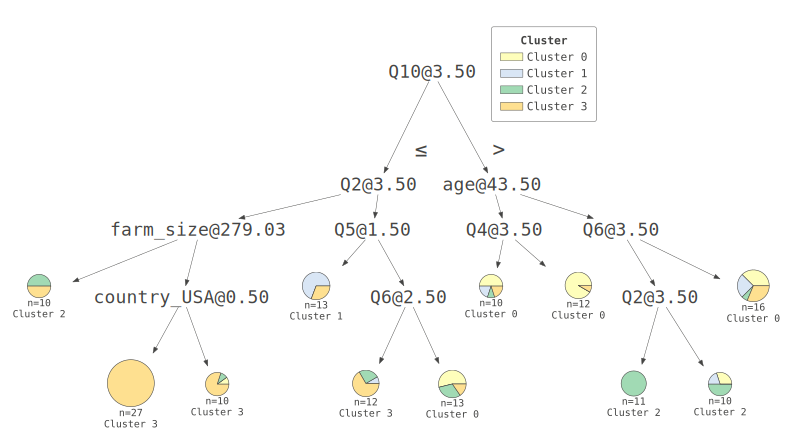

In [70]:
import dtreeviz

# get transformed data
feature_names_t = clf.named_steps['prep'].get_feature_names_out()
X_train_t = pd.DataFrame(clf.named_steps['prep'].transform(X_train), columns=feature_names_t)
y_train_t = label_encoder.fit_transform(y_train)

viz_model = dtreeviz.model(clf.named_steps['tree'],
                           X_train=X_train_t, 
                           y_train=y_train_t,
                           feature_names=feature_names_t,
                           target_name='Cluster', 
                           class_names=[f'Cluster {i}' for i in label_encoder.classes_])


viz_model.view(scale=1.5, fancy=False, fontname="monospace")

### Evaluate the classifier (be careful when interpreting this)

The classification tree here predicts unsupervised cluster assignments, which may or may not have real-world meaning. 
If a classification tree can accurately reproduce clusters, this could mean that:

 - the clusters are driven by clear, interpretable patterns
 - there is a structure in the data that matches human-understandable features

This is useful to confirm that clusters aren't just noise.

In [ ]:
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix

y_pred = label_encoder.inverse_transform(clf.predict(X_test))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=np.nan))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))



Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.88      0.56         8
           1       0.67      0.50      0.57         4
           2       1.00      0.50      0.67         8
           3       0.83      0.62      0.71        16

    accuracy                           0.64        36
   macro avg       0.73      0.62      0.63        36
weighted avg       0.76      0.64      0.65        36


Confusion Matrix:
[[ 7  0  0  1]
 [ 2  2  0  0]
 [ 2  1  4  1]
 [ 6  0  0 10]]
